In [1]:
import tensorflow as tf


# maintain consistent performance
tf.random.set_seed(1)  # define a semente para garantir reprodutibilidade

# confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # verifica quantas gpus estao disponiveis


Num GPUs Available:  0


In [2]:
from tensorflow.keras.datasets import fashion_mnist

# load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
import numpy as np

# merge the training and testing sets
dataset = np.concatenate([x_train, x_test], axis=0)  # combina os conjuntos de treino e teste pois nao tem nenhuma utilizade o conjunto teste

# normalize the images from [0,255] to [0,1]
dataset = np.expand_dims(dataset, -1).astype("float32") / 255  # normaliza as imagens para o intervalo [0,1], o que a funcao sigmoid espera


In [4]:
BATCH_SIZE = 64 #tamanho do lote

# convolution layers work 3 channels
dataset = np.reshape(dataset, (-1, 28, 28, 1))  # reorganiza as imagens para a forma esperada pela rede convolucional

# create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)  # cria um objeto Dataset do TensorFlow a partir dos dados

# set the batch size otherwise it reads one image at a time
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)  # embaralha os dados e define o tamanho do lote


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# hiperparametro do tamanho do vetor de ruido
NOISE_DIM = 150

# define o gerador da GAN
generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(NOISE_DIM,)),  # camada de entrada com o vetor de ruido
    layers.Dense(7 * 7 * 256),  # camada densa para gerar um vetor com tamanho adequado
    layers.Reshape(target_shape=(7, 7, 256)),  # reorganiza o vetor para a forma (7, 7, 256)
    layers.Conv2DTranspose(256, 3, strides=2, padding="same"),  # camada convolucional transposta
    layers.LeakyReLU(alpha=0.2),  # LeakyReLU como camada separada
    layers.Conv2DTranspose(128, 3, strides=2, padding="same"),  # outra camada convolucional transposta
    layers.LeakyReLU(alpha=0.2),  # outra camada de LeakyReLU
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")  # ultima camada gera a imagem final
])

generator.summary()  # exibe o resumo do modelo gerador


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 128)       0

In [6]:
#faremos o descriminador (muito parecido com o vae, tanto a parte anterior, quanto essa)

# design a discriminator with downsampling layers
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),  # camada de entrada com a imagem de tamanho 28x28 na cor cinza
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),  # camada convolucional para reduzir a resolução
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),  # outra camada convolucional
  layers.Flatten(),  # achata a saída das camadas convolucionais para vetor
  layers.Dense(64, activation="relu"),  # camada densa
  layers.Dropout(0.2),  # dropout para regularização
  layers.Dense(1, activation="sigmoid")  # camada final para prever se a imagem é real ou falsa
])

discriminator.summary()  # exibe o resumo do modelo discriminador


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

In [7]:
#Responsavel pela loos function, semelhante aos VAEs

# set different learning rates for the generator and the discriminator
# we want to maintain the game balance until we arrive at the nash-equilibria
# if the discriminator gets very strong or very weak the adversarial game fails
# higher learning rates impact the stability of the adversarial game severely
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)  # otimização para o gerador com taxa de aprendizagem baixa
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)  # otimização para o discriminador com taxa de aprendizagem um pouco maior

# binary classifier (real or fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)  # função de perda para classificação binária

# accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()  # métrica de acurácia para o gerador
dAccMetric = tf.keras.metrics.BinaryAccuracy()  # métrica de acurácia para o discriminador


In [8]:
# treina o discriminador, calculando a perda com base nas imagens reais e falsas,
#aplicando os gradientes para atualizar os pesos e retornando a perda e a acuracia do mesmo

@tf.function
def trainDStep(data):
    batchSize = tf.shape(data)[0]  # obtém o tamanho do lote de dados
    noise = tf.random.normal(shape=(batchSize, NOISE_DIM))  # gera ruído aleatório para o gerador
    
    y_true = tf.concat([
        tf.ones((batchSize, 1)),  # rótulos reais
        tf.zeros((batchSize, 1))  # rótulos falsos
    ], axis=0)
    
    with tf.GradientTape() as tape:
        fake = generator(noise)  # gera imagens falsas usando o gerador
        x = tf.concat([data, fake], axis=0)  # junta as imagens reais e falsas
        y_pred = discriminator(x)  # o discriminador faz a previsão sobre as imagens
        discriminatorLoss = lossFn(y_true, y_pred)  # calcula a perda do discriminador
    
    grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)  # calcula os gradientes
    optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))  # aplica os gradientes para atualizar os pesos
    dAccMetric.update_state(y_true, y_pred)  # atualiza a métrica de acurácia do discriminador
    
    return {"discriminator_loss": discriminatorLoss, "discriminator_accuracy": dAccMetric.result()}  # retorna a perda e a acuráci


In [9]:
# treina o gerador, calculando a perda com base na avaliação do discriminador, 
#aplicando os gradientes para atualizar os pesos do gerador e retornando a perda e a acurácia do mesmo

@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  # when training the generator, we want it to maximize the probability that its
  # output is classified as real, remember the min-max game
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

In [10]:
from matplotlib import pyplot as plt


def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

C:\Users\Higor\.conda\envs\tensorflow-env\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


E:0, Loss G:0.6587, Loss D:0.0939, Acc G:%0.41, Acc D:%96.44


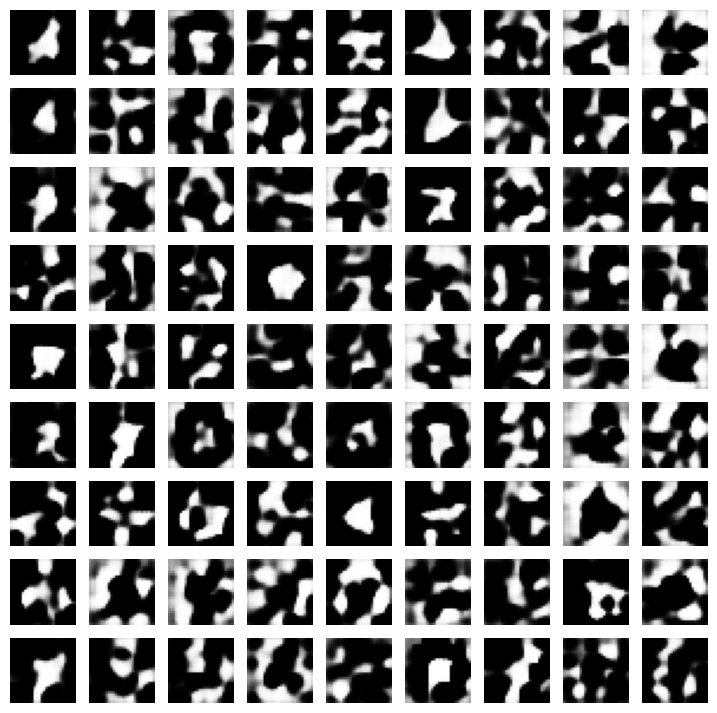

E:1, Loss G:0.6659, Loss D:0.0764, Acc G:%1.10, Acc D:%98.13
E:2, Loss G:0.6683, Loss D:0.0748, Acc G:%1.19, Acc D:%98.08
E:3, Loss G:0.6734, Loss D:0.0613, Acc G:%1.24, Acc D:%98.04
E:4, Loss G:0.6795, Loss D:0.0451, Acc G:%1.16, Acc D:%98.16
E:5, Loss G:0.6582, Loss D:0.1273, Acc G:%1.27, Acc D:%98.08


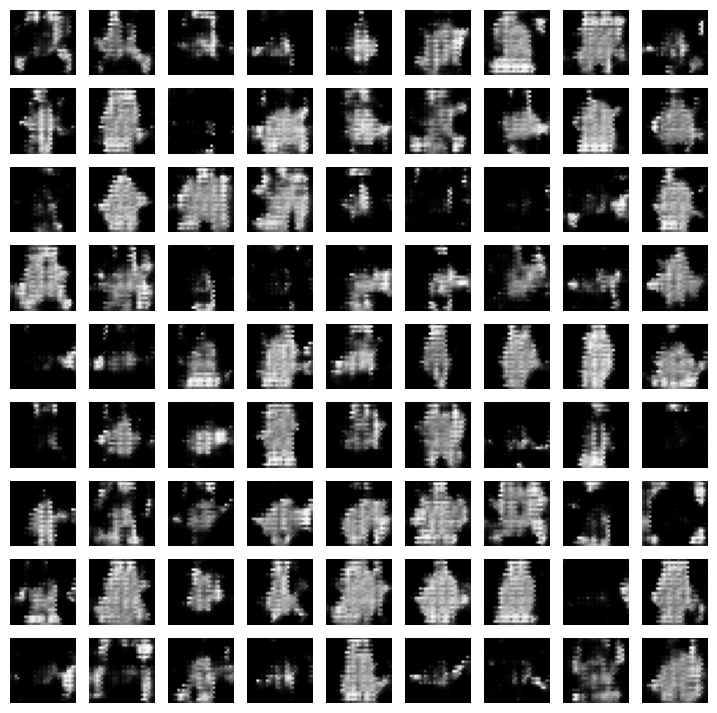

E:6, Loss G:0.5920, Loss D:0.3626, Acc G:%2.34, Acc D:%96.82
E:7, Loss G:0.5819, Loss D:0.3442, Acc G:%3.73, Acc D:%95.15
E:8, Loss G:0.5894, Loss D:0.3123, Acc G:%4.19, Acc D:%94.41
E:9, Loss G:0.5866, Loss D:0.3209, Acc G:%4.57, Acc D:%93.81


In [15]:
# modificado para reduzir o consumo de GPU, utilizando 'torch.no_grad()' no treinamento do gerador para evitar cálculos desnecessários de gradientes.

import torch

for epoch in range(10):  # Loop principal de treinamento por 30 épocas

  dLossSum = 0  # acumula a perda do discriminador
  gLossSum = 0  # acumula a perda do gerador
  dAccSum = 0   # acumula a acurácia do discriminador
  gAccSum = 0   # acumula a acurácia do gerador
  cnt = 0       # contador de lotes

  for batch in dataset:  # percorre o dataset lote por lote
    
    dLoss = trainDStep(batch)  # treina o discriminador
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    with torch.no_grad():  # Evita o cálculo de gradientes durante o treinamento do gerador
        gLoss = trainGStep(batch)  # treina o gerador
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    cnt += 1  # incrementa o contador de lotes

  # exibe o desempenho do modelo a cada época
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))
    
  if epoch % 5 == 0:  # a cada 5 epocas, gera e exibe imagens
    plotImages(generator)


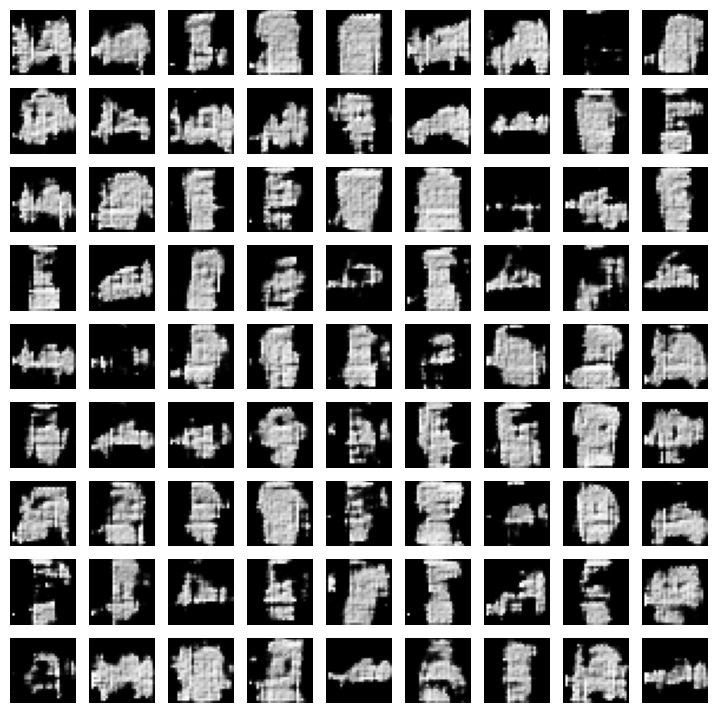

In [16]:

images = generator(np.random.normal(size=(81, NOISE_DIM)))  # fera 81 imagens com o gerador treinado

from matplotlib import pyplot as plt  # importa biblioteca para plotagem

plt.figure(figsize=(9, 9))  # define o tamanho da figura

for i, image in enumerate(images):  # itera sobre as imagens geradas
    plt.subplot(9,9,i+1)  # organiza as imagens em uma grade 9x9
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")  # exibe a imagem em escala de cinza
    plt.axis('off')  # remove os eixos para melhor visualização

plt.show();  # mostra as imagens geradai